In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02):
  drips = []
  for i in range(len(data) - min_window):
    # ข้าม drip ก่อนหน้า
    if drips and i < drips[-1]['end_index']:
      continue
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+min_window].min()
    drip_pct = (low_price - close_price) / close_price
    
    # ตรวจสอบเงื่อนไขการลดลงมากกว่า 3%
    if drip_pct <= threshold:
      end_index = i + min_window - 1
      duration = end_index - i + 1
      
      for j in range(i, i+max_window):
        high = data['high'].iloc[j]
        low = data['low'].iloc[j]
        open_price = data['open'].iloc[j]
        close = data['close'].iloc[j]
        
        # คำนวณ high-to-low % และตรวจสอบว่า open-to-close เป็นบวก
        high_to_low_pct = (high - low) / low
        if (close > open_price) and (high_to_low_pct > increase_threshold):
          end_index = j
          duration = end_index - i + 1
          drip_pct = (low_price - close_price) / close_price
          break
      
      low_time = data.index[end_index]
      
      if duration >= min_window and duration <= max_window:
        drips.append({
          'start_time': data.index[i],
          'close_price': close_price,
          'low_price': low_price,
          'drip_pct': drip_pct * 100,  # แปลงเป็น %
          'end_index': end_index,
          'duration': duration,
          'low_time': low_time,
        })
        
  
  return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data = data["2021-01-01":]
drips = detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02)

Summary of Price Returns After Drip Low (3% in 6-48 Hours):
 Hours  Count  Mean (%)  Std (%)    Min (%)   Max (%)  Median (%)  25th Percentile (%)  75th Percentile (%)
     2    463  1.268653 2.937284 -13.641298 13.258915    1.236489             0.087645             2.767892
     4    464  1.312509 3.252034 -14.219569 17.041220    1.245426            -0.272344             3.039730
     6    464  1.297684 3.427499 -12.806762 14.623754    1.355446            -0.572998             3.209968
     8    464  1.241805 3.669139 -12.780000 13.114164    1.348075            -0.421481             3.345005
    10    463  1.141165 3.894082 -12.645013 13.181315    1.340578            -0.671123             3.304223
    12    463  1.246870 3.959722 -13.905207 12.476377    1.411115            -0.683067             3.350698
    14    463  1.346699 4.163093 -12.579038 13.609264    1.542123            -0.677229             3.499662
    16    463  1.341668 4.174014 -14.242323 14.325819    1.401138           

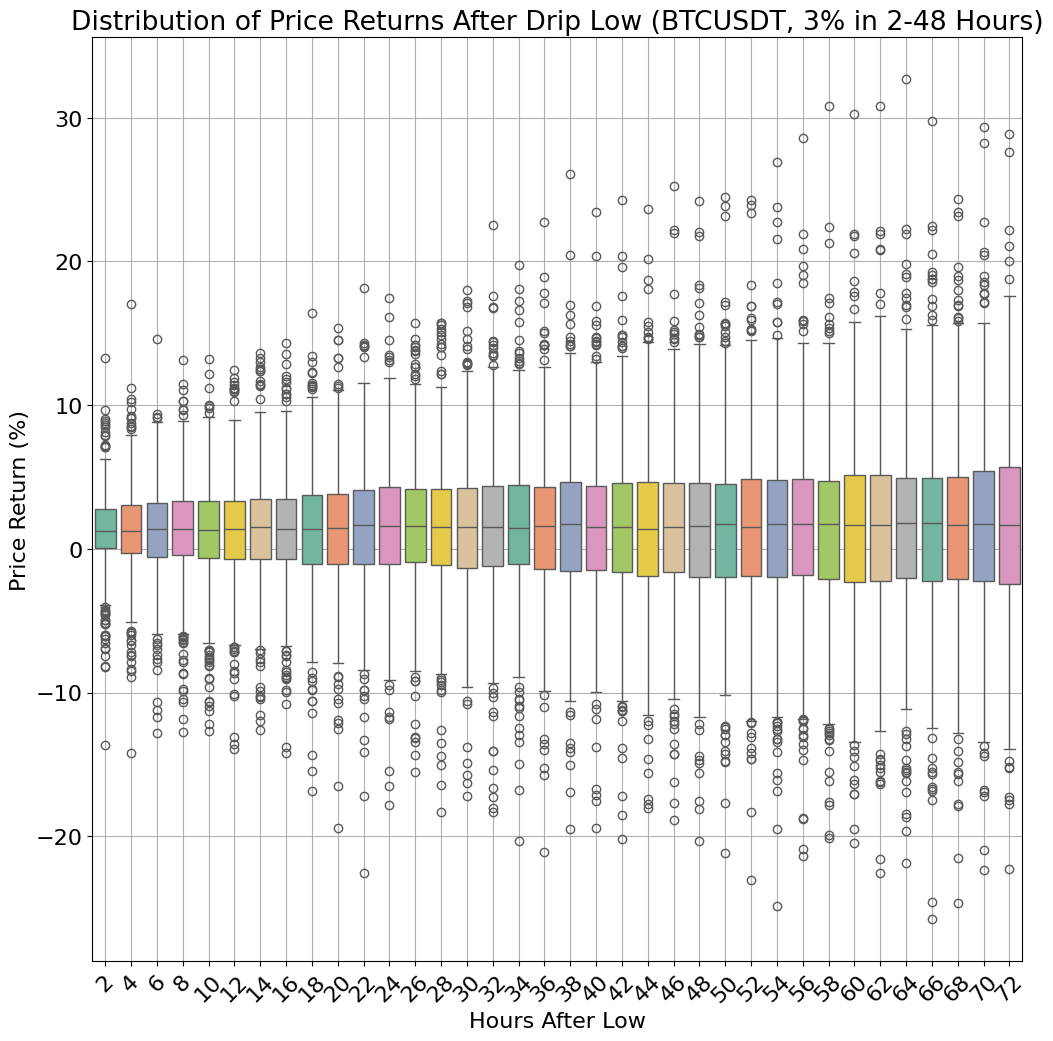

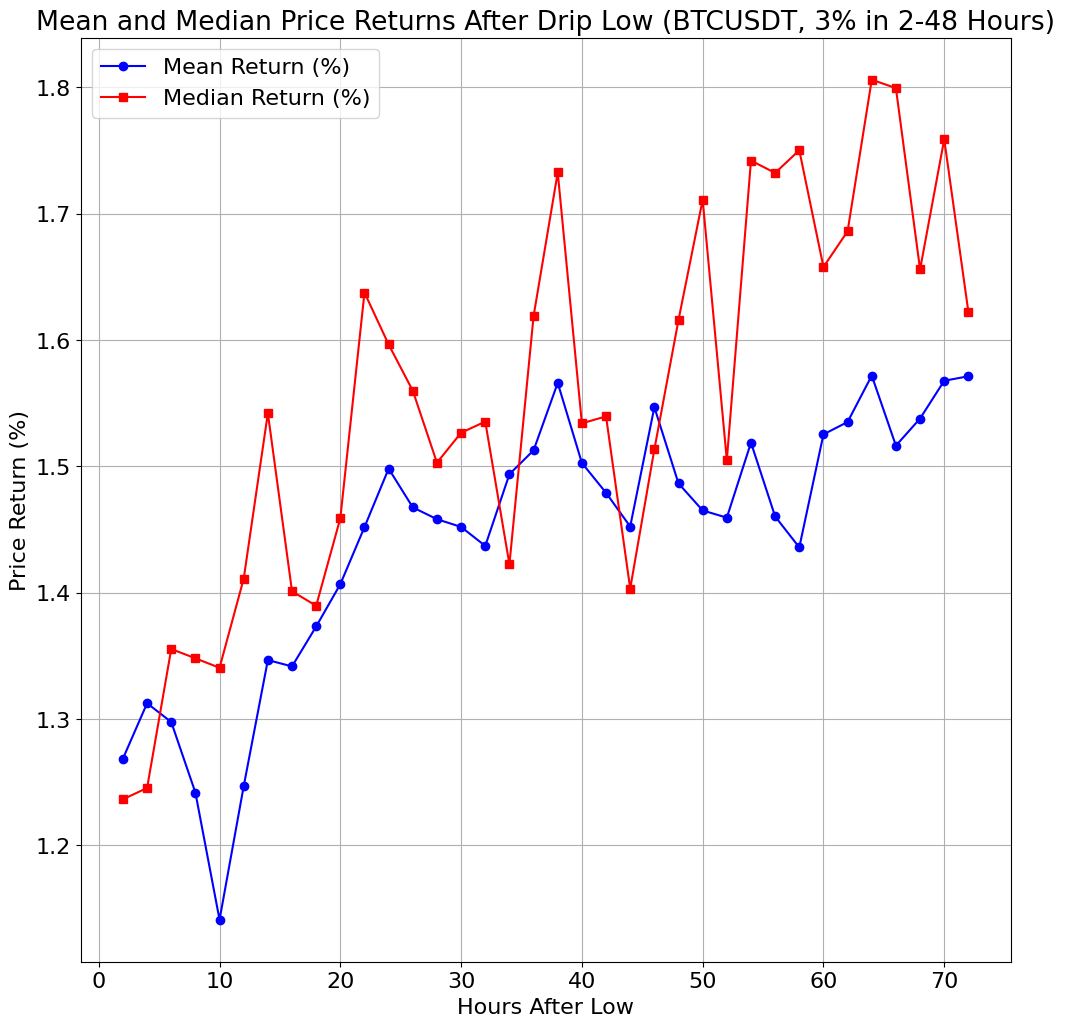

In [4]:
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close']]

# ฟังก์ชันคำนวณอัตราการเปลี่ยนแปลงราคา
def calculate_returns(row, data, hours):
    low_time = row['low_time']
    low_price = row['low_price']
    try:
        # หา index ของเวลาหลังจาก low_time + hours
        target_time = low_time + pd.Timedelta(hours=hours)
        if target_time in data.index:
            close_price = data.loc[target_time, 'close']
            return ((close_price - low_price) / low_price) * 100
        else:
            # หา index ที่ใกล้ที่สุดถ้า target_time ไม่มีใน data
            closest_idx = data.index[data.index > low_time].get_loc(target_time, method='nearest')
            close_price = data.iloc[closest_idx]['close']
            return ((close_price - low_price) / low_price) * 100
    except:
        return np.nan

# สร้าง DataFrame สำหรับเก็บผลลัพธ์
hours_range = list(range(2, 73, 2))  # 2, 4, 6, ..., 72 ชั่วโมง
returns_data = pd.DataFrame()

# คำนวณอัตราการเปลี่ยนแปลงสำหรับแต่ละช่วงเวลา
for hours in hours_range:
    drips[f'return_{hours}h'] = drips.apply(lambda row: calculate_returns(row, data, hours), axis=1)
    returns_data[hours] = drips[f'return_{hours}h']

# 1. สรุปสถิติของอัตราการเปลี่ยนแปลง
print("Summary of Price Returns After Drip Low (3% in 6-48 Hours):")
summary_stats = []
for hours in hours_range:
    stats = {
        'Hours': hours,
        'Count': returns_data[hours].count(),
        'Mean (%)': returns_data[hours].mean(),
        'Std (%)': returns_data[hours].std(),
        'Min (%)': returns_data[hours].min(),
        'Max (%)': returns_data[hours].max(),
        'Median (%)': returns_data[hours].median(),
        '25th Percentile (%)': returns_data[hours].quantile(0.25),
        '75th Percentile (%)': returns_data[hours].quantile(0.75)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# 2. สร้าง Boxplot สำหรับอัตราการเปลี่ยนแปลงในแต่ละช่วงเวลา
plt.figure(figsize=(12, 12))
sns.boxplot(data=returns_data, palette='Set2')
plt.title('Distribution of Price Returns After Drip Low (BTCUSDT, 3% in 2-48 Hours)')
plt.xlabel('Hours After Low')
plt.ylabel('Price Return (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. สร้าง Lineplot แสดงค่าเฉลี่ยและมัธยฐาน
plt.figure(figsize=(12, 12))
plt.plot(hours_range, summary_df['Mean (%)'], marker='o', label='Mean Return (%)', color='blue')
plt.plot(hours_range, summary_df['Median (%)'], marker='s', label='Median Return (%)', color='red')
plt.title('Mean and Median Price Returns After Drip Low (BTCUSDT, 3% in 2-48 Hours)')
plt.xlabel('Hours After Low')
plt.ylabel('Price Return (%)')
plt.legend()
plt.grid(True)
plt.show()